In [15]:
import re 
import string
import timestring
from sklearn.linear_model import LinearRegression, LogisticRegression
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score, KFold
import glob, os
import numpy as np
from sklearn import svm
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [16]:
def tokenize(text):
    punc_re = '[' + '\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\_\\{\\|\\}' + ']'
    text = text.lower()
    text = re.sub('#(\S+)', r'HASHTAG_\1', text)
    text = re.sub('@\S+', 'MENTION', text)
    text = re.sub('http\S+', 'THIS_IS_A_URL', text)
    text = re.sub(r'(.)\1\1\1+', r'\1', text)
    text = re.sub(r'[0-9]', '9', text)
    toks = []
    for tok in text.split():
        tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
        tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
        for subtok in tok.split():
            if re.search('\w', subtok):
                toks.append(subtok)
    return toks

In [17]:
vectorizer = TfidfVectorizer(decode_error='ignore',ngram_range=(1, 2), max_df=1.0, min_df=2,use_idf=True, tokenizer=tokenize)

In [18]:
DIR = '/data/2/protest'

In [19]:
def read_keywords(path):
    return [s.strip().lower() for s in open(path)]
    
keywords = read_keywords(DIR + '/keywords.txt')
keywords

['foradilma', 'fora dilma', 'forapt', 'fora pt', 'vemprarua', 'vem pra rua']

In [20]:
import os
import random

def getRandomFile(path):
  """
  Returns a random filename, chosen among the files of the given path.
  """
  files = os.listdir(path)
  index = random.randrange(0, len(files))
  return files[index]

In [21]:
import os, io, json, codecs

def matches_keywords(text, keywords):
    """ Return true if any keyword is a substring of this text, ignoring case. """
    text = text.lower()
    for kw in keywords:
        if kw in text:
            return True
    return False

def filename2user(fname):
    """Convert filename like this
      /data/2/protest/Timeline/MandinhaSimone.txt.txt
    into a username like
      MandinhaSimone
    """
    return re.sub(r'^([^\.]+)\..+', r'\1', os.path.basename(fname))

def iterate_instances(path, keywords, negative_window,files_train):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """
    for fname in files_train:
        user = filename2user(fname)
        lines = []
        #print(user)
        for i, line in enumerate(open(path+fname)):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= negative_window and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > negative_window and matches_keywords(js['text'], keywords):
                yield (' '.join(lines), 1, user)
                yield (' '.join(lines[:-negative_window]), 0, user)
                break
            lines.append(js['text'])
            
            
y = []
users = []
negative_window = 10
# The loop below iterates over each instance and vectorizes the text.
# Simulataneously, we append to the y (labels) and users lists.
# We do this to avoid having to store all the text in memory at once and to 
# only require one loop through the files.
files_train=set()
while len(files_train)< 250:
    files_train.add(getRandomFile(DIR + '/Timeline/'))
    
iterator = iterate_instances(DIR + '/Timeline/', keywords, negative_window, files_train)
X = vectorizer.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not y.append(x[1]))
#print('read %d instances into X matrix with shape %s' % (len(users), str(X.shape)))
#print('label distribution=', Counter(y))
#y = np.array(y)
#users = np.array(users)
print(type(y))
#iterator = iterate_instances(DIR + '/Timeline', keywords, negative_window)
#i=list(iterator)


<class 'list'>


In [8]:
print(len(set(files_train)))

250


In [9]:
y = np.array(y)
model_mod = LogisticRegression(penalty='l2', C=2.6)
model_mod.fit(X, y)


# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

# 10 Cross-validation accuracy
cv = KFold(len(y), 10, shuffle=False)  # Don't shuffle b/c we don't want a user in both training and testing set.
accuracies = []
for train_ind, test_ind in cv:
    model_mod.fit(X[train_ind],y[train_ind])   
    accuracies.append(accuracy_score(y[test_ind], model_mod.predict(X[test_ind])))
    
print('Average 10-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies)))

predicted = model_mod.predict(X)
print('accuracy on training data=%.4f' % accuracy(y, predicted))

Average 10-fold cross validation accuracy=0.5159 (std=0.02)
accuracy on training data=0.5946


In [11]:
def iterate_Testing_instances(path, keywords, negative_window,files_test):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """ 
    for fname in files_test:#glob.glob(path + '/*.txt'):
        user = filename2user(fname)
        
        lines = []
        var=None
        tweetlist=[]
        count=0
        for i, line in enumerate(open(path+fname)):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= negative_window and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > negative_window and matches_keywords(js['text'], keywords):
                print(user)
                var=''
                for l in lines:
                    var = var + l
                    yield(var,user)
                    count=count+1
                    if count==1500:
                        break
                #tweetlist=[]
                var=None
                break
            lines.append(js['text'])
            
y = []
users = []
negative_window = 10
# The loop below iterates over each instance and vectorizes the text.
# Simulataneously, we append to the y (labels) and users lists.
# We do this to avoid having to store all the text in memory at once and to 
# only require one loop through the files.
files_test=[]
for _, _, arquivos in os.walk(DIR + '/Timeline/'): arquivos#list of all files in the directory
for f in arquivos:
    if f not in set(files_train):
        files_test.append(f)

print(len(arquivos))
print(len(set(files_test)))
print(len(files_train))
iterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window, files_test)
X_ = vectorizer.transform(x[0] for x in iterator1 if not users.append(x[1]))
print('read %d instances into X matrix with shape %s' % (len(users), str(X_.shape)))
#print('label distribution=', Counter(y))
#y = np.array(y)
#users = np.array(users)
#print(type(y))
iterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window,files_test)
iter1=list(iterator1)

321
71
250
marcocanavarro
ClaraCamargoL
mcberinguy
samanthaeandre
GusttavoGrossi
casa_dos_pobres
edsonfelix902
CamilaCanever
RafaHellMetal
LuxAjuda
NeiOliver
pauuloph10
umgeher
LaurenSousa1
PaulXbrow2
junior_nicolini
ItagibaFrancez
clodo_junior
TarsilaCrusius
ClauderSouto
decunhaz
FilAirton
LcyaLima
hugopradosob
Cileidealves
fr_jhs
thyaggus
Aristotelesbh
lfnaascimento
Jailson83_
turmadochapeu_
PaThY_luZ
nikaetata
anaparaizo
samoelmattosjr
guilhermeplopes
Pauliiiinhas
renata_rfb
arthurcatanic
TomDeBrito
oreinhadasilva
pedrosnp
Ministerio_J
samueel1
stenio8708
DaviWesler
vulgogold
arrobateus
ViniciusPezatti
mourajubs
Prlazaroramon
MAUROROBERTO13
romulovenades
Rodrigomr316
JenniPalmita
luis_simaro
emersonbraz
luccalnd
tiosergioluiz
antonionetoAC
hanahney
nannicolorada
aderson_santana
read 45012 instances into X matrix with shape (45012, 1056117)
marcocanavarro
ClaraCamargoL
mcberinguy
samanthaeandre
GusttavoGrossi
casa_dos_pobres
edsonfelix902
CamilaCanever
RafaHellMetal
LuxAjuda
NeiOlive

In [12]:
pred=model_mod.predict_proba(X_)

In [99]:
iter1[1]

('@SiteCorinthians muitos gols em 2012@FrederaFilipina combinado',
 'AugustoCampos3')

In [ ]:
count =0
dictv = defaultdict(list)
for o in zip(iter1,pred):
    #print(o[0][1])
    dictv[o[0][1]].append(o[1][1])
print(len(dictv))

Populating the interactive namespace from numpy and matplotlib
63


`%matplotlib` prevents importing * from pylab and numpy


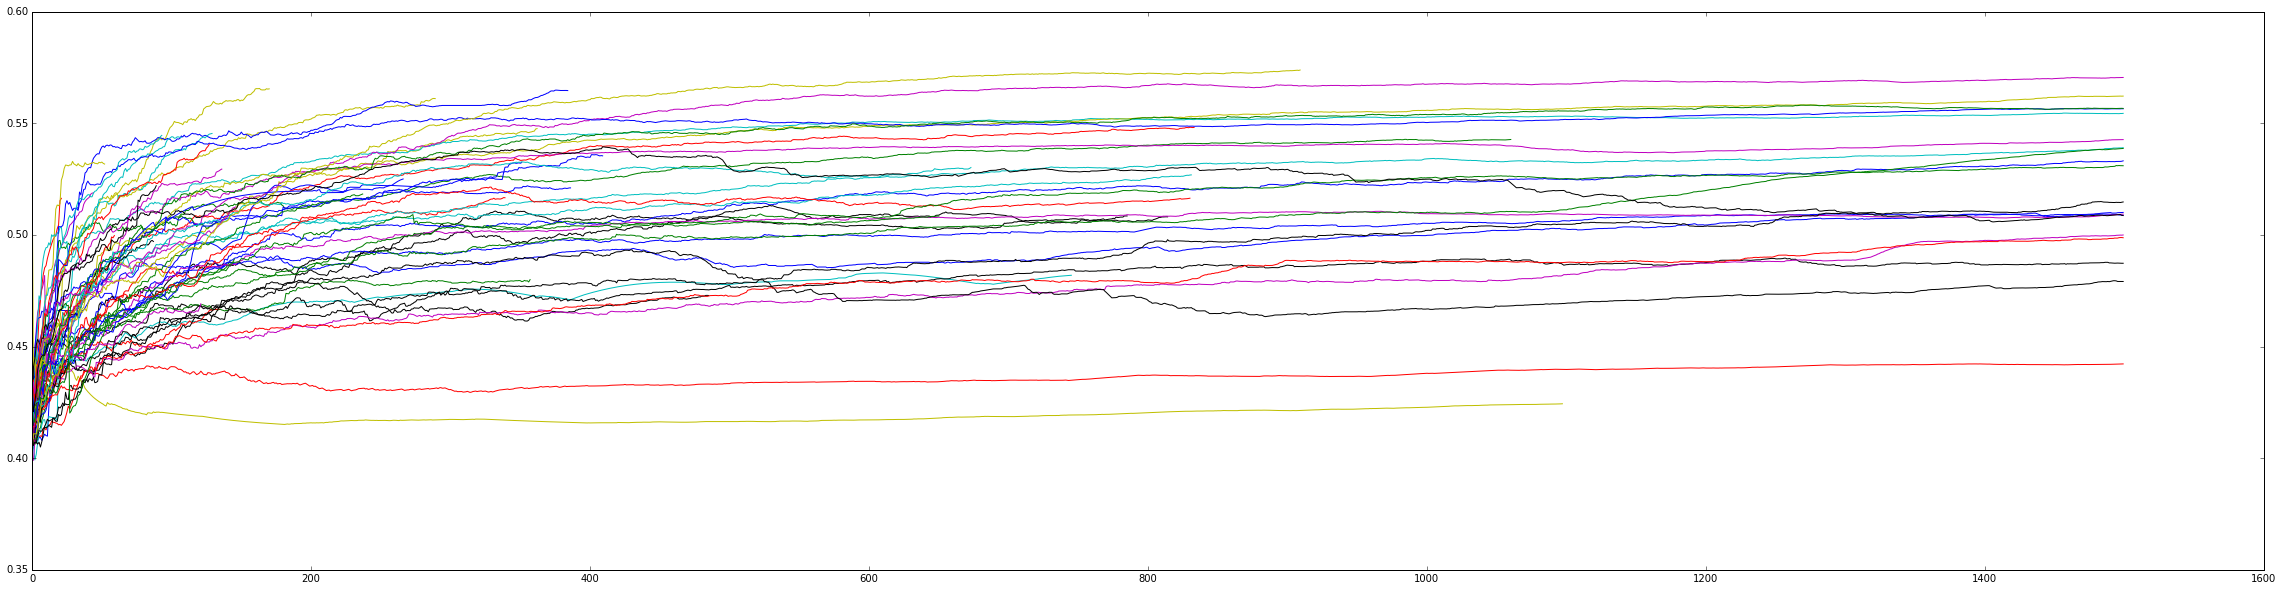

In [14]:
%pylab inline
fig = plt.figure(figsize=(40,10))
for k,v in dictv.items():
    plt.plot(dictv[k])
print(len(dictv))